# Aprendizaje No Supervisado 
## Classifica els diferents vols

**Descripció**

Anem a practicar i a familiaritzar-nos amb algoritmes de clustering.

## Nivell 1
### Exercici 1

Classifica els diferents vols utilitzant l'algorisme de **K-means**.

## Nivell 2
### Exercici 2

Classifica els diferents vols utilitzant l'algorisme de **clustering jeràrquic**.

## Nivell 3
### Exercici 3

Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

In [1]:
# Librerías

# Data wrangling
#--------------------------------------------------

import numpy as np
import pandas as pd

import missingno as msno 

# Data Visualization
#--------------------------------------------------

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
#--------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer

# Clustering
#--------------------------------------------------
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

from kmodes.kprototypes import KPrototypes

# Pipelines / Cross validation / Hyp. tunning
#--------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Metrics
#--------------------------------------------------
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Librerías para visualización de modelos
#--------------------------------------------------
from kneed import KneeLocator
import scipy.cluster.hierarchy as sch



Para este ejercicio voy a seguir el siguiente proceso:

1. Carga de los datos.
2. Preprocesado.
3. Clustering con K-Means.
4. Clustering con DBSCAN.
5. Clustering con Gausian Mixture Model.
6. Clustering Jerárquico.
7. Evaluación de los diferentes métodos y conclusiones.

## 1. Carga de archivos.

Utilizo el archivo *'vuelos_final.csv'*.

In [2]:
# Carga de los archivos
df=pd.read_csv('vuelos_final.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936756 entries, 0 to 1936755
Data columns (total 32 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date               object 
 1   DayOfYear          int64  
 2   Year               int64  
 3   Month              int64  
 4   Day                int64  
 5   DayOfWeek          int64  
 6   Hour               int64  
 7   Status             object 
 8   ArrDelay           float64
 9   DepDelay           float64
 10  TaxiIn             float64
 11  TaxiOut            float64
 12  CancellationCode   object 
 13  UniqueCarrier      object 
 14  CarrierName        object 
 15  TailNum            object 
 16  YearOfManufact     float64
 17  Origin             object 
 18  Dest               object 
 19  FlightNum          int64  
 20  Distance           int64  
 21  Skyway             object 
 22  city_or            object 
 23  state_or           object 
 24  country            object 
 25  city_dest         

## 2. Preprocesado.
### 2.1. Muestreo del dataset.

Nuestro dataset tiene cerca de 2.000.000 de observaciones, esto hace que la ejecución de algunos de los algoritmos que voy a aplicar sea demasiado costosa en tiempo o inviable. De hecho en el caso del clustering jerárquicose desaconseja su uso para conjuntos de datos demasiado grandes.

Para solucionar este problema voy a trabajar con una muestra del dataset del 1%

In [4]:
sub_df=df.sample(frac=0.01,random_state=1987)


### 2.2. Creación de nuevas variables.

Voy a crear una nueva variables que nos indiquen el número de vuelos por hora y aeropuerto.


In [5]:
# New feature - Number of flights por hour on origin
sub_df=sub_df.join(df.groupby(['Origin','Date','Hour'])[['FlightNum']].count(),
                   how='left',
                   on=['Origin','Date','Hour'],
                   rsuffix='_h')
sub_df.rename(columns={'FlightNum_h':'flights_hour'}, inplace=True)

### 2.2. Eliminación variables categóricas.


Elimino variables que no aportaban valor como:

 - Date,Year

Y variables categórigas.

 - Status, CancellationCode.
 - CarrierName, TailNum, FlightNum.
 - UniqueCarrier, Origin, Dest, Skyway.
 - city_or, state_or, city_dest, state_dest, country.

In [6]:
# Drop features
sub_df.drop(axis=1,columns=['Date','Year','CancellationCode','CarrierName','TailNum','FlightNum',
                            'city_or','state_or','city_dest','state_dest','country','Status',
                           # 'UniqueCarrier', 'Origin', 'Dest','Skyway'
                           ], inplace=True)

### 2.3. Eliminación duplicados.



In [7]:
# Elimino duplicados
sub_df.drop_duplicates(inplace=True);

### 2.4. Tratamiento missing values.

Veamos donde tengo valores nulos: 

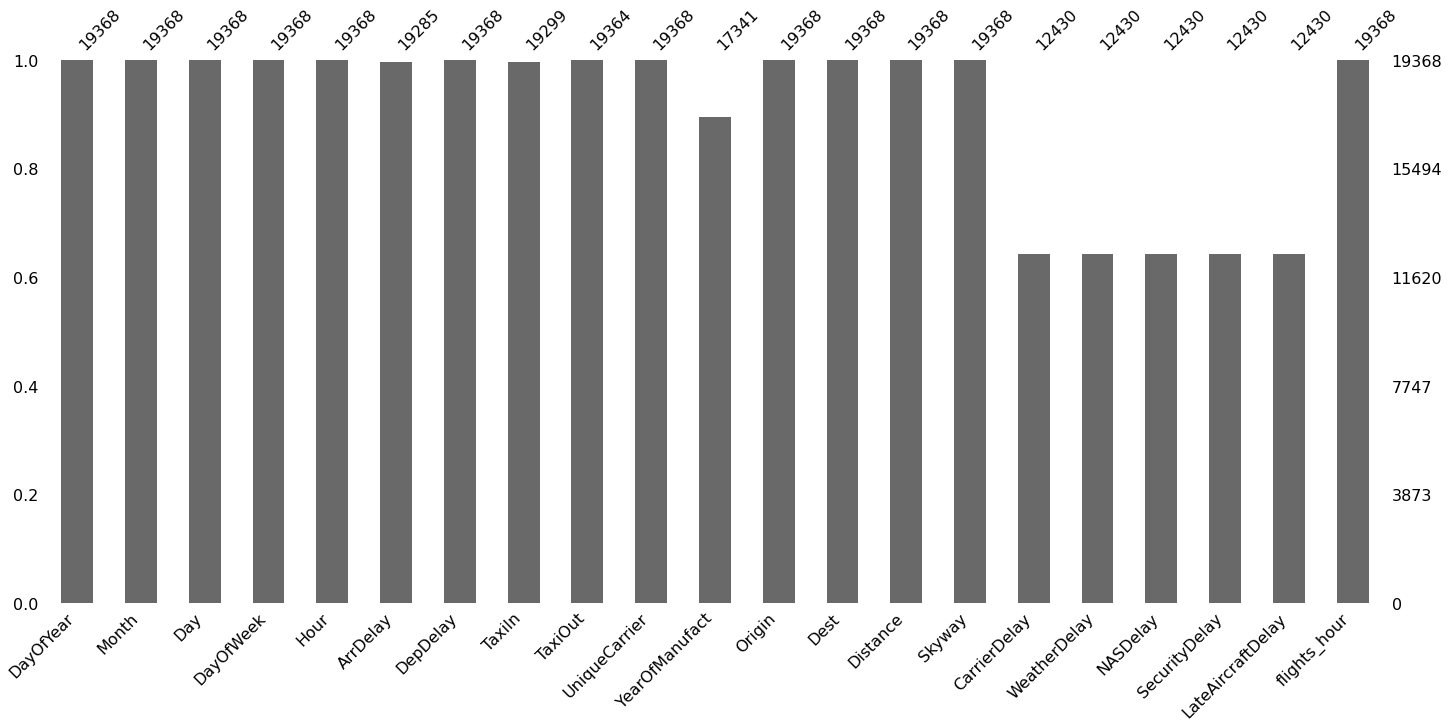

In [8]:
# Missing Values
msno.bar(sub_df);

Primero imputo los valores nulos de los campos año con la el valor medio.

In [9]:
# Mean imputing for year of manufacturing

# Instantiate imputer
year_imputer=SimpleImputer(strategy='mean')

# Executing imputation
sub_df.YearOfManufact=year_imputer.fit_transform(sub_df.YearOfManufact.values.reshape(-1,1))

A continuación para el conjunto de las variables que asignan retraso a una causa imputo valor 0.

In [10]:
# Zero imputing for Delay Causes

# Instantiate imputer
causes_imputer=SimpleImputer(strategy='constant', fill_value=0)

# Executing imputation
causes=['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
sub_df[causes]=causes_imputer.fit_transform(sub_df[causes])

Y por último elimino los valores nulos para TaxiIn, TaxiOut y ArrDelay.

In [11]:
# Delaying Nan in Taxi In, Taxi Out and ArrDelay
sub_df.dropna(inplace=True)

In [12]:
sub_df.isna().sum().sum()

0

## 3. Clustering con K-means.

Una vez extraída nuestra muestra vamos a ver que resultado da una clusterización con K-means.

De manera muy breve podemos decir que K-Means es un algoritmo que genera agrupaciones de datos alrededor de un centroide, clasificando cada dato con la misma etiqueta que el centroide más cercano. 

El algoritmo empieza con un valor inicial de los centroides y a partir del cual genera los n clusters. Una vez que tiene asignados los clusters se calcula la nueva ubicación de los centroides de cada cluster. Con esa nueva ubicación de los centroides se vuelve a repetir una asignación de los datos a los n clusters. Este proceso se repite hasta que convergen las ubicaciones de los centroides.

Como peculiaridad, los clusteres generados por este algoritmo tienen una forma esférica. Además hay que añadir que este algoritmo es determinista y puede dar resultados diferentes dependiendo de donde se inicialice. 



In [13]:
# Asiganción de X
X=sub_df.copy()

Para ejecutar el algoritmo K-Means tenemos que introducir el número de clusters que queremos que agrupe.

Voy a iterar el algoritmo para diferentes valores de k. Para cada k calcularé la __inercia__ y el valor del __silhouette score__.

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19285 entries, 891206 to 1427618
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DayOfYear          19285 non-null  int64  
 1   Month              19285 non-null  int64  
 2   Day                19285 non-null  int64  
 3   DayOfWeek          19285 non-null  int64  
 4   Hour               19285 non-null  int64  
 5   ArrDelay           19285 non-null  float64
 6   DepDelay           19285 non-null  float64
 7   TaxiIn             19285 non-null  float64
 8   TaxiOut            19285 non-null  float64
 9   UniqueCarrier      19285 non-null  object 
 10  YearOfManufact     19285 non-null  float64
 11  Origin             19285 non-null  object 
 12  Dest               19285 non-null  object 
 13  Distance           19285 non-null  int64  
 14  Skyway             19285 non-null  object 
 15  CarrierDelay       19285 non-null  float64
 16  WeatherDelay   

In [15]:
# Frecuency encoding
geo=['UniqueCarrier','Origin','Dest','Skyway']
for categoria in geo: 
    # mapeo frecuencia de aparición de variables en train dataset
    cat_mapping=X.groupby(categoria).size()/len(X)*100
    # Imputo frecuencias en train y test dataset
    X[categoria]=X[categoria].map(cat_mapping)
    

In [16]:
Scaler=StandardScaler()
#----------------------------------------------------------------

# Lista con la inercia según k
sse=[]

# Lista con el score silhouette coef.
sil_coeficient=[]

#----------------------------------------------------------------


for k in range(2,30):
    # Pipeline - Primer paso estandarizar / segundo paso Kmeans
    C_Kmean=Pipeline(steps=[('Estandarizar',StandardScaler()),
                            ('Cluster',KMeans(n_clusters=k,random_state=1987))])

    # Ajuste declustering Kmeans (k)
    C_Kmean.fit(X)
    
    # Inercia y lista con valores de inercia ordenado de k=2 a K=n
    inertia=C_Kmean[1].inertia_
    sse.append(inertia)
    
    # Silhouette score para cada k
    labels=C_Kmean[1].labels_
    sil=silhouette_score(Scaler.fit_transform(X), 
                         labels,
                         #sample_size=80000,random_state=1984
                        )
    sil_coeficient.append(sil)
    

Una vez obtenidas los modelos para diferentes k clusteres podemos ver gráficamente como evoluciona la inercia (squared standard error) al aumentar k.

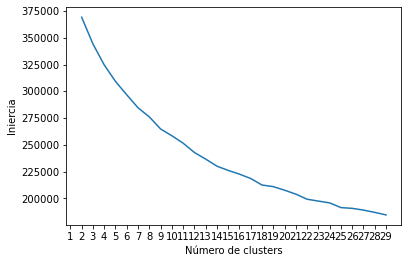

In [17]:
plt.plot(range(2, 30), sse)
plt.xticks(range(1, 30))
plt.xlabel('Número de clusters')
plt.ylabel('Iniercia')
plt.show()

Para estimar el punto óptimo de clusters podemos usar el 'método del codo'. Para este caso voy a utilizar la librería **Kneed** que nos ayuda a localizar el k óptimo a partir del cuál la bajado de inercia no es significativa.

In [18]:
kl=KneeLocator(range(2,30),sse,curve='convex',direction='decreasing')
kl.elbow

12

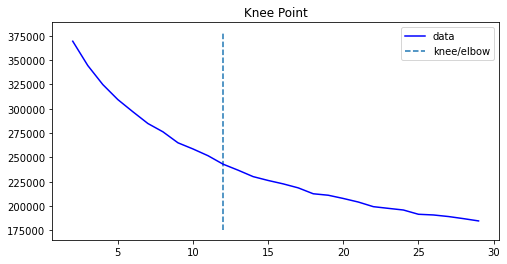

In [19]:
kl.plot_knee(figsize=(8,4))

Un método de evaluación de la cohesión de los clusters es el coeficiente Silhouette que hemos calculado anteriormente. El coeficiente silhouette puede tomar valores entre -1 y 1, donde 1 significa que los puntos están muy cerca de su propio clúster y lejos de otros clústeres, mientras que -1 indica que los puntos están cerca de los clústeres vecinos.

Veamos la evolución del coeficiente silhouette en función de k.

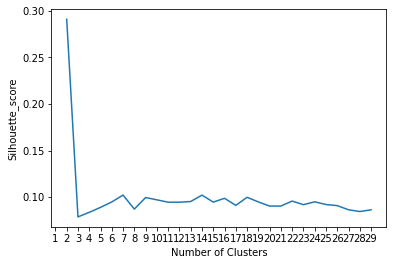

In [20]:
plt.plot(range(2, 30), sil_coeficient)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette_score")
plt.show()

Parece que los mejores valores de k son 2 y 12.

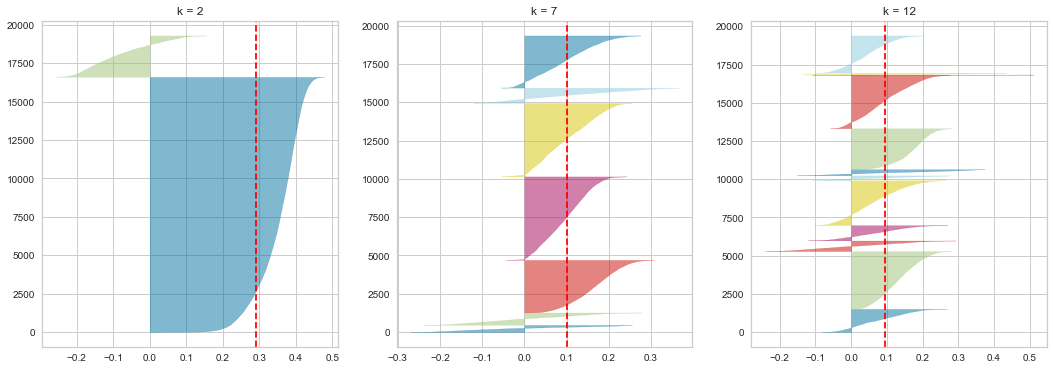

In [21]:
from yellowbrick.cluster import SilhouetteVisualizer
Scaler=StandardScaler()
X_transformed=Scaler.fit_transform(X)

fig,(ax1,ax2,ax3)=plt.subplots(figsize=(18,6),nrows=1,ncols=3)

#ax1
visualizer = SilhouetteVisualizer(KMeans(n_clusters=2,random_state=1987), colors='yellowbrick',ax=ax1)
visualizer.fit(X_transformed)        # Fit the data to the visualizer
ax1.set_title('k = 2')               # Title

#ax2
visualizer = SilhouetteVisualizer(KMeans(n_clusters=7,random_state=1987), colors='yellowbrick',ax=ax2)
visualizer.fit(X_transformed)        # Fit the data to the visualizer
ax2.set_title('k = 7')               # Title

#ax3
visualizer2 = SilhouetteVisualizer(KMeans(n_clusters=12,random_state=1987), colors='yellowbrick',ax=ax3)
visualizer2.fit(X_transformed)        # Fit the data to the visualizer
ax3.set_title('k = 12');               # Title

## 3.1. Clustering con K-Proptotype.

K-Prototypes es un algoritmo muy similar a K-Means, pero que ofrece una ventaja cuando trabajamos con datos numéricos y categóricos. El algoritmo funciona igual para las variables numéricas midiendo la distancia euclídea entre variables numéricas, pero también mide la distancia entre variables categóricas usando en número de categorías comunes.

In [22]:
X_2=sub_df.copy()

In [23]:

X_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19285 entries, 891206 to 1427618
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DayOfYear          19285 non-null  int64  
 1   Month              19285 non-null  int64  
 2   Day                19285 non-null  int64  
 3   DayOfWeek          19285 non-null  int64  
 4   Hour               19285 non-null  int64  
 5   ArrDelay           19285 non-null  float64
 6   DepDelay           19285 non-null  float64
 7   TaxiIn             19285 non-null  float64
 8   TaxiOut            19285 non-null  float64
 9   UniqueCarrier      19285 non-null  object 
 10  YearOfManufact     19285 non-null  float64
 11  Origin             19285 non-null  object 
 12  Dest               19285 non-null  object 
 13  Distance           19285 non-null  int64  
 14  Skyway             19285 non-null  object 
 15  CarrierDelay       19285 non-null  float64
 16  WeatherDelay   

In [24]:
Scaler=StandardScaler()

# Estandarizar Numéricas
X_2[X_2.select_dtypes(exclude=object).columns.to_list()]=Scaler.fit_transform(X_2[X_2.select_dtypes(exclude=object).columns.to_list()])

# Indices de columna de variables categóricas
catColumnsPos = [X_2.columns.get_loc(col) for col in list(X_2.select_dtypes('object').columns)]

#----------------------------------------------------------------

# Lista con la inercia según k
cost_list=[]

#----------------------------------------------------------------

for k in range(2,30):
    # K-prototypes
    C_proto=KPrototypes(n_clusters=k,random_state=1987,n_jobs=-2)

    # Ajuste declustering Kmeans (k)
    C_proto.fit(X,
                categorical=catColumnsPos)
    
    # Coeficiente de Coste y lista con valores de inercia ordenado de k=2 a K=n
    cost=C_proto.cost_
    cost_list.append(cost)
    
    

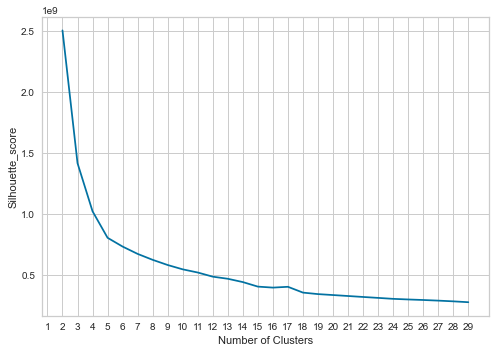

In [25]:
plt.plot(range(2, 30), cost_list)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette_score")
plt.show()


## 4. Clustering con DBSCAN.

Como vimos en el punto anterior K-means nos daba unos valores del coeficiente silhouete cercanos a 0.3, es decir que los clusters no estaban muy bien definidos.

Vamos a analizar otro enfoque a la hora de hacer agrupaciones, en este caso voy a ver que resultados da un algoritmo de clusterización que genere clusteres en función de la densidad, en este caso voy a utilizar DBSCAN.

In [26]:
Scaler=StandardScaler()
sil_DBSCAN=[]
for e in [2,3,4,5,10]:
    C_DBSCAN=Pipeline(steps=[
                             ('Estandarizar',StandardScaler()),
                             ('Cluster',DBSCAN(eps=e,
                                                  min_samples=10,
                                                  algorithm='ball_tree'))])
    
    C_DBSCAN.fit(X)
    sil_DBSCAN.append(silhouette_score(Scaler.fit_transform(X),C_DBSCAN[1].labels_,))
    
    print('esp= ',e,' ',np.unique(C_DBSCAN[1].labels_, return_counts=True))


esp=  2   (array([-1,  0,  1,  2], dtype=int64), array([ 7014, 12254,    10,     7], dtype=int64))
esp=  3   (array([-1,  0,  1,  2,  3], dtype=int64), array([ 1216, 18038,    15,     9,     7], dtype=int64))
esp=  4   (array([-1,  0,  1], dtype=int64), array([  305, 18971,     9], dtype=int64))
esp=  5   (array([-1,  0], dtype=int64), array([  106, 19179], dtype=int64))
esp=  10   (array([-1,  0], dtype=int64), array([   11, 19274], dtype=int64))


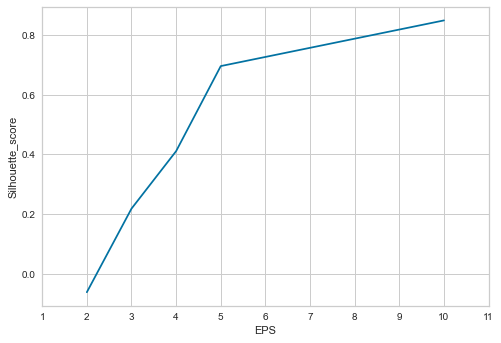

In [27]:
plt.plot([2,3,4,5,10], sil_DBSCAN)
plt.xticks(range(1, 12))
plt.xlabel("EPS")
plt.ylabel("Silhouette_score")
plt.show()

## 5. Clustering con Gausian Mixture Model.

El Gaussian Mixture Model (abreviado como GMM) es un modelo probabilístico en el que se considera que las observaciones siguen una distribución probabilística formada por la combinación de múltiples distribuciones normales (componentes). Puede entenderse como una generalización de K-means con la que, en lugar de asignar cada observación a un único cluster, se obtiene una distribución probabilidad de pertenencia a cada uno.

Veamos una implementación del modelo.

In [28]:
Scaler=StandardScaler()
#----------------------------------------------------------------

# Lista con el score silhouette coef.
GMM_sil_coeficient=[]
GMM_BIC=[]

#----------------------------------------------------------------


for k in range(2,30):
    # Pipeline - Primer paso estandarizar / segundo paso GMM
    C_GMM=Pipeline(steps=[('Estandarizar',StandardScaler()),
                         ('Cluster',GaussianMixture(n_components=k,
                                                    covariance_type='full',
                                                    max_iter=300))])
    
    # Ajuste de clustering GMM (k)
    C_GMM.fit(X)
    
    
    # Silhouette score para cada k
    labels=C_GMM.fit_predict(X)
    sil=silhouette_score(Scaler.fit_transform(X), 
                         labels,)
    GMM_sil_coeficient.append(sil)
    
    m_BIC=C_GMM[1].bic(X)
    GMM_BIC.append(m_BIC)
    

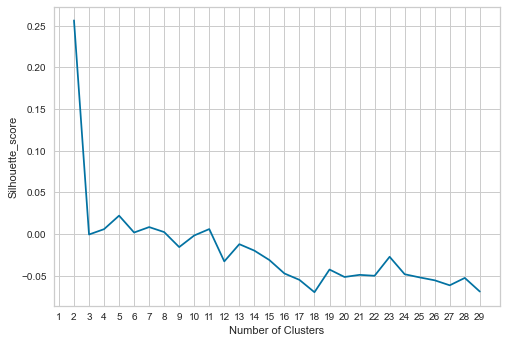

In [29]:
plt.plot(range(2, 30), GMM_sil_coeficient)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette_score")
plt.show()

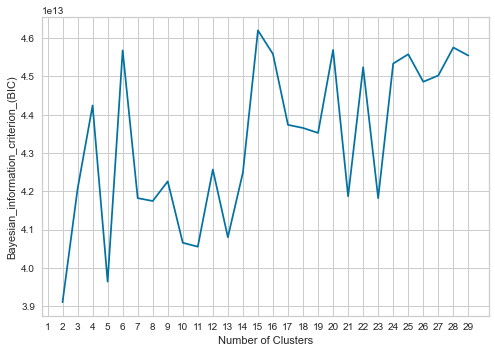

In [30]:
plt.plot(range(2, 30), GMM_BIC)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("Bayesian_information_criterion_(BIC)")
plt.show()

# Cluster Jerarquico

El algortimo de clúster jerárquico agrupa los datos basándose en la distancia entre cada uno y buscando que los datos que están dentro de un clúster sean los más similares entre sí.

En una representación gráfica, como veremos más adelante, los elementos quedan anidados en jerarquías con forma de árbol. 

In [31]:
Scaler=StandardScaler()
#----------------------------------------------------------------

# Lista con el score silhouette coef.
Arb_sil_coeficient=[]

#----------------------------------------------------------------


for k in range(2,30):
    # Pipeline - Primer paso estandarizar / segundo paso Arbol jerárquico
    C_Arbol=Pipeline(steps=[('Estandarizacion',Scaler),
                        ('Cluster_jerarquico', AgglomerativeClustering(n_clusters=k))])
    
    # Ajuste de clustering arbol jerárquico (k)
    C_Arbol.fit(X)
        
    # Silhouette score para cada k
    labels=C_Arbol[1].labels_
    sil=silhouette_score(Scaler.fit_transform(X), 
                         labels,)
    Arb_sil_coeficient.append(sil)
    

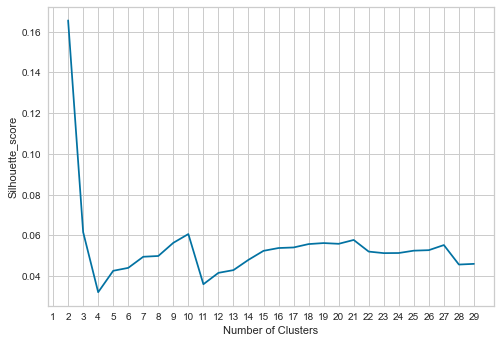

In [32]:
plt.plot(range(2, 30), Arb_sil_coeficient)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette_score")
plt.show()

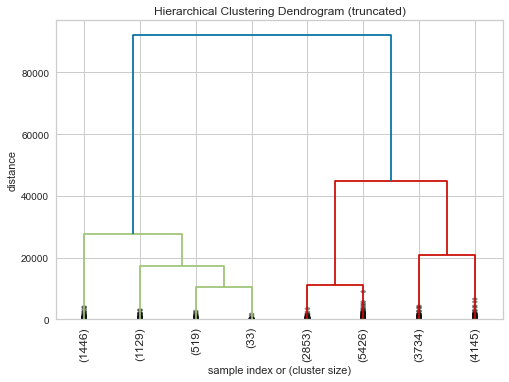

In [33]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
sch.dendrogram(
                sch.linkage(X, method='ward'),
                truncate_mode='lastp',  # show only the last p merged clusters
                p=8,  # show only the last p merged clusters
                leaf_rotation=90.,
                leaf_font_size=12.,
                show_contracted=True,  # to get a distribution impression in truncated branches
                )
plt.show()



Como hemos visto hay diferentes métodos de clusterización que dan resultados muy diferentes. En parte debido al enfoque que tienen para generar las agrupaciones.